In [2]:
# from google.colab import drive
# drive.mount('/content/drive/')


# Sentiment Analysis of IMDB Movie Reviews
**Prepared by - Jakir Hasan**

26-05-2023

# Importing modules

In [3]:
#Load the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords

from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize

from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer

from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

import os
import warnings

# Importing Dataset

In [4]:
imdb_data = pd.read_csv("/content/drive/MyDrive/imdb/IMDB Dataset.csv")

In [5]:
print(imdb_data.shape)
imdb_data.head(5)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
for i, row in imdb_data.iterrows():
  print(len(row["review"]))
  print(row["review"])
  print("-----------\n\n")
  if i == 2:
    break

1761
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to th

# Exploratory data analysis

In [7]:
imdb_data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [8]:
imdb_data["sentiment"].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [9]:
imdb_data["review"].value_counts()

Loved today's show!!! It was a variety and not solely cooking (which would have been great too). Very stimulating and captivating, always keeping the viewer peeking around the corner to see what was coming up next. She is as down to earth and as personable as you get, like one of us which made the show all the more enjoyable. Special guests, who are friends as well made for a nice surprise too. Loved the 'first' theme and that the audience was invited to play along too. I must admit I was shocked to see her come in under her time limits on a few things, but she did it and by golly I'll be writing those recipes down. Saving time in the kitchen means more time with family. Those who haven't tuned in yet, find out what channel and the time, I assure you that you won't be disappointed.                                                                                                                                                                                                                

# Splitting the dataset

In [10]:
train_reviews = imdb_data["review"][:40000]
train_sentiments = imdb_data["sentiment"][:40000]

test_reviews = imdb_data["review"][40000:]
test_sentiments = imdb_data["sentiment"][40000:]

print(train_reviews.shape, train_sentiments.shape)
print(test_reviews.shape, test_sentiments.shape)

(40000,) (40000,)
(10000,) (10000,)


# Test normalization

In [11]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
print(len(stopword_list), type(stopword_list))

179 <class 'list'>


In [13]:
stopword_list[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

# Removing html strips and noise text

In [14]:
def strip_html(text):
  soup = BeautifulSoup(text, "html.parser")
  return soup.get_text()

text = "Hilarious, clean, light-hearted, and quote-worthy. What else can you ask for in a film? This is my all-time, number one favorite movie. Ever since I was a little girl, I've dreamed of owning a blue van with flames and an observation bubble.<br /><br />The cliché characters in ridiculous situations are what make this film such great fun. The wonderful comedic chemistry between Stephen Furst (Harold) and Andy Tennant (Melio) make up most of my favorite parts of the movie. And who didn't love the hopeless awkwardness of Flynch? Don't forget the airport antics of Leon's cronies, dressed up as Hari Krishnas: dancing, chanting and playing the tambourine--unbeatable! The clues are genius, the locations are classic, and the plot is timeless.<br /><br />A word to the wise, if you didn't watch this film when you were little, it probably won't win a place in your heart today. But nevertheless give it a chance, you may find that"
print(len(text))

ans = strip_html(text)
print(len(ans), type(ans))
print(ans)

930
906 <class 'str'>
Hilarious, clean, light-hearted, and quote-worthy. What else can you ask for in a film? This is my all-time, number one favorite movie. Ever since I was a little girl, I've dreamed of owning a blue van with flames and an observation bubble.The cliché characters in ridiculous situations are what make this film such great fun. The wonderful comedic chemistry between Stephen Furst (Harold) and Andy Tennant (Melio) make up most of my favorite parts of the movie. And who didn't love the hopeless awkwardness of Flynch? Don't forget the airport antics of Leon's cronies, dressed up as Hari Krishnas: dancing, chanting and playing the tambourine--unbeatable! The clues are genius, the locations are classic, and the plot is timeless.A word to the wise, if you didn't watch this film when you were little, it probably won't win a place in your heart today. But nevertheless give it a chance, you may find that


In [15]:
def remove_between_square_brackets(text):
  return re.sub('\[[^]]*\]', '', text)

text = "hi[[jakir]kemon(acho)valo[{achi}]]dost]]"
print(len(text))
ans = remove_between_square_brackets(text)
print(len(ans), ans, type(ans))


40
24 hikemon(acho)valo]dost]] <class 'str'>


In [16]:
imdb_data["review"][1]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

In [17]:
def denoise_text(text):
  text = strip_html(text)
  text = remove_between_square_brackets(text)
  return text

imdb_data["review"] = imdb_data["review"].apply(denoise_text)

<ipython-input-14-55259e060f5e>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [18]:
imdb_data["review"][1]

'A wonderful little production. The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well done.'

# Removing special characters

In [19]:
def remove_special_characters(text, remove_digits=True):
  pattern = r'[^a-zA-Z0-9\s]'
  text = re.sub(pattern, '', text)
  return text

imdb_data["review"] = imdb_data["review"].apply(remove_special_characters)
imdb_data["review"][1]

'A wonderful little production The filming technique is very unassuming very oldtimeBBC fashion and gives a comforting and sometimes discomforting sense of realism to the entire piece The actors are extremely well chosen Michael Sheen not only has got all the polari but he has all the voices down pat too You can truly see the seamless editing guided by the references to Williams diary entries not only is it well worth the watching but it is a terrificly written and performed piece A masterful production about one of the great masters of comedy and his life The realism really comes home with the little things the fantasy of the guard which rather than use the traditional dream techniques remains solid then disappears It plays on our knowledge and our senses particularly with the scenes concerning Orton and Halliwell and the sets particularly of their flat with Halliwells murals decorating every surface are terribly well done'

# Text stemming

In [20]:
def simple_stemmer(text):
  ps = nltk.porter.PorterStemmer()
  text = ' '.join([ps.stem(word) for word in text.split()])
  return text

imdb_data["review"] = imdb_data["review"].apply(simple_stemmer)
print(len(imdb_data["review"][1]))
imdb_data["review"][1]

843


'a wonder littl product the film techniqu is veri unassum veri oldtimebbc fashion and give a comfort and sometim discomfort sens of realism to the entir piec the actor are extrem well chosen michael sheen not onli ha got all the polari but he ha all the voic down pat too you can truli see the seamless edit guid by the refer to william diari entri not onli is it well worth the watch but it is a terrificli written and perform piec a master product about one of the great master of comedi and hi life the realism realli come home with the littl thing the fantasi of the guard which rather than use the tradit dream techniqu remain solid then disappear it play on our knowledg and our sens particularli with the scene concern orton and halliwel and the set particularli of their flat with halliwel mural decor everi surfac are terribl well done'

# Removing stopwords

In [21]:
stop = set(stopwords.words('english'))
print(len(stop))

179


In [22]:
def remove_stopwords(text, is_lower_case=False):
  tokens = tokenizer.tokenize(text)
  tokens = [token.strip() for token in tokens]

  if is_lower_case:
    filtered_tokens = [token for token in tokens if token not in stopword_list]
  else:
    filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]

  filtered_text = ' '.join(filtered_tokens)
  return filtered_text

imdb_data["review"] = imdb_data["review"].apply(remove_stopwords)
print(len(imdb_data["review"][1]))
imdb_data["review"][1]

595


'wonder littl product film techniqu veri unassum veri oldtimebbc fashion give comfort sometim discomfort sens realism entir piec actor extrem well chosen michael sheen onli ha got polari ha voic pat truli see seamless edit guid refer william diari entri onli well worth watch terrificli written perform piec master product one great master comedi hi life realism realli come home littl thing fantasi guard rather use tradit dream techniqu remain solid disappear play knowledg sens particularli scene concern orton halliwel set particularli flat halliwel mural decor everi surfac terribl well done'

# Normalized train reviews


In [23]:
norm_train_reviews = imdb_data["review"][:40000]
norm_train_reviews[0]

'one review ha mention watch 1 oz episod youll hook right thi exactli happen meth first thing struck oz wa brutal unflinch scene violenc set right word go trust thi show faint heart timid thi show pull punch regard drug sex violenc hardcor classic use wordit call oz nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda em citi home manyaryan muslim gangsta latino christian italian irish moreso scuffl death stare dodgi deal shadi agreement never far awayi would say main appeal show due fact goe show wouldnt dare forget pretti pictur paint mainstream audienc forget charm forget romanceoz doesnt mess around first episod ever saw struck nasti wa surreal couldnt say wa readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard wholl sold nickel inmat wholl kill order get away well manner middl class inmat turn prison bitch due lack street skill prison exp

In [24]:
print(type(norm_train_reviews))

<class 'pandas.core.series.Series'>


# Norm test reviews

In [25]:
norm_test_reviews = imdb_data["review"][40000:]
norm_test_reviews[45005]

'read review watch thi piec cinemat garbag took least 2 page find somebodi els didnt think thi appallingli unfunni montag wasnt acm humour 70 inde ani era thi isnt least funni set sketch comedi ive ever seen itll till come along half skit alreadi done infinit better act monti python woodi allen wa say nice piec anim last 90 second highlight thi film would still get close sum mindless drivelridden thi wast 75 minut semin comedi onli world semin realli doe mean semen scatolog humour onli world scat actual fece precursor joke onli mean thi handbook comedi tit bum odd beaver niceif pubesc boy least one hand free havent found playboy exist give break becaus wa earli 70 way sketch comedi go back least ten year prior onli way could even forgiv thi film even made wa gunpoint retro hardli sketch clown subtli pervert children may cut edg circl could actual funni come realli quit sad kept go throughout entir 75 minut sheer belief may save genuin funni skit end gave film 1 becaus wa lower scoreand

In [26]:
print(norm_test_reviews.shape)

(10000,)


# Bags of words model

In [27]:
cv = CountVectorizer(min_df=0, max_df=1, binary=False, ngram_range=(1, 3))

cv_train_reviews = cv.fit_transform(norm_train_reviews)
print(cv_train_reviews.shape)

(40000, 6208633)


In [28]:
cv_test_reviews = cv.transform(norm_test_reviews)
print(cv_test_reviews.shape)

(10000, 6208633)


In [29]:
print(type(cv_train_reviews))
cv_train_reviews[0:0]

<class 'scipy.sparse._csr.csr_matrix'>


<0x6208633 sparse matrix of type '<class 'numpy.int64'>'
	with 0 stored elements in Compressed Sparse Row format>

In [30]:
print("BOW_cv_train:", cv_train_reviews.shape)
print("BOW_cv_test:", cv_test_reviews.shape)

BOW_cv_train: (40000, 6208633)
BOW_cv_test: (10000, 6208633)


# Term Frequency-Inverse Document Frequency Model (TFIDF)

In [31]:
tv = TfidfVectorizer(min_df=0, max_df=1, use_idf=True, ngram_range=(1, 3))
tv_train_reviews = tv.fit_transform(norm_train_reviews)
tv_test_reviews = tv.transform(norm_test_reviews)

print(tv_train_reviews.shape, tv_test_reviews.shape)

(40000, 6208633) (10000, 6208633)


In [32]:
print(tv_train_reviews)

  (0, 5550035)	0.06388765649999383
  (0, 2208493)	0.06388765649999383
  (0, 5803757)	0.06388765649999383
  (0, 5667836)	0.06388765649999383
  (0, 1034917)	0.06388765649999383
  (0, 522636)	0.06388765649999383
  (0, 3359070)	0.06388765649999383
  (0, 3921412)	0.06388765649999383
  (0, 5935461)	0.06388765649999383
  (0, 1783711)	0.06388765649999383
  (0, 4212365)	0.06388765649999383
  (0, 4916660)	0.06388765649999383
  (0, 5151581)	0.06388765649999383
  (0, 2970305)	0.06388765649999383
  (0, 1522645)	0.06388765649999383
  (0, 614425)	0.06388765649999383
  (0, 4212078)	0.06388765649999383
  (0, 5626302)	0.06388765649999383
  (0, 2742907)	0.06388765649999383
  (0, 963749)	0.06388765649999383
  (0, 3427584)	0.06388765649999383
  (0, 3319951)	0.06388765649999383
  (0, 5983330)	0.06388765649999383
  (0, 427712)	0.06388765649999383
  (0, 2191826)	0.06388765649999383
  :	:
  (39999, 1387028)	0.08276058886023664
  (39999, 2972266)	0.08276058886023664
  (39999, 1593876)	0.08276058886023664
  (399

# Labeling the sentiment text

In [33]:
lb = LabelBinarizer()
sentiment_data = lb.fit_transform(imdb_data["sentiment"])
print(sentiment_data.shape)

(50000, 1)


In [34]:
print(sentiment_data)

[[1]
 [1]
 [1]
 ...
 [0]
 [0]
 [0]]


# Split the sentiment data

In [35]:
train_sentiments = sentiment_data[:40000]
test_sentiments = sentiment_data[40000:]

print(train_sentiments)
print("----------------\n")
print(test_sentiments)

[[1]
 [1]
 [1]
 ...
 [1]
 [0]
 [0]]
----------------

[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


# Modeling the dataset

In [36]:
lr = LogisticRegression(penalty='l2', max_iter=500, C=1, random_state=42)
lr_bow = lr.fit(cv_train_reviews, train_sentiments)
print(lr_bow)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1, max_iter=500, random_state=42)


In [37]:
lr_tfidf = lr.fit(tv_train_reviews, train_sentiments)
print(lr_tfidf)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1, max_iter=500, random_state=42)


# Logistic Regression model performance on test dataset

In [38]:
lr_bow_predict = lr.predict(cv_test_reviews)
print(lr_bow_predict)

[0 0 0 ... 0 1 1]


In [39]:
lr_tfidf_predict = lr.predict(tv_test_reviews)
print(lr_tfidf_predict)

[0 0 0 ... 0 1 1]


# Accuracy of the model

In [40]:
lr_bow_score = accuracy_score(test_sentiments, lr_bow_predict)
print(lr_bow_score)

0.7514


In [41]:
lr_tfidf_score = accuracy_score(test_sentiments, lr_tfidf_predict)
print(lr_tfidf_score)

0.7498


# Print classification report

In [42]:
lr_bow_report = classification_report(test_sentiments, lr_bow_predict, target_names=['Positive', 'Negative'])
print(lr_bow_report)

              precision    recall  f1-score   support

    Positive       0.75      0.75      0.75      4993
    Negative       0.75      0.75      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



In [43]:
lr_tfidf_report = classification_report(test_sentiments, lr_tfidf_predict, target_names=['Positive', 'Negative'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.74      0.77      0.75      4993
    Negative       0.76      0.73      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



# Confusion matrix

In [44]:
cm_bow = confusion_matrix(test_sentiments, lr_bow_predict, labels=[1, 0])
print(cm_bow)

[[3770 1237]
 [1249 3744]]


In [45]:
cm_tfidf = confusion_matrix(test_sentiments, lr_tfidf_predict, labels=[1, 0])
print(cm_tfidf)

[[3662 1345]
 [1157 3836]]


# Stochastic Gradient Descent or Linear Support Vector Machines for bag of words and tfidf features

In [47]:
svm = SGDClassifier(loss='hinge', max_iter=500, random_state=42)
svm_bow = svm.fit(cv_train_reviews, train_sentiments)
print(svm_bow)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDClassifier(max_iter=500, random_state=42)


In [48]:
svm_tfidf = svm.fit(tv_train_reviews, train_sentiments)
print(svm_tfidf)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDClassifier(max_iter=500, random_state=42)


# Model performance on test data

In [49]:
svm_bow_predict = svm.predict(cv_test_reviews)
print(svm_bow_predict)

[1 1 0 ... 1 1 1]


In [50]:
svm_tfidf_predict = svm.predict(tv_test_reviews)
print(svm_tfidf_predict)

[1 1 1 ... 1 1 1]


# Accuracy of the model

In [51]:
svm_bow_score = accuracy_score(test_sentiments, svm_bow_predict)
print(svm_bow_score)

0.583


In [52]:
svm_tfidf_score = accuracy_score(test_sentiments, svm_tfidf_predict)
print(svm_tfidf_score)

0.5112


# Print the classification report

In [53]:
svm_bow_report = classification_report(test_sentiments, svm_bow_predict, target_names=['Positive', 'Negative'])
print(svm_bow_report)

              precision    recall  f1-score   support

    Positive       0.94      0.18      0.30      4993
    Negative       0.55      0.99      0.70      5007

    accuracy                           0.58     10000
   macro avg       0.74      0.58      0.50     10000
weighted avg       0.74      0.58      0.50     10000



In [54]:
svm_tfidf_report = classification_report(test_sentiments, svm_tfidf_predict, target_names=['Positive', 'Negative'])
print(svm_tfidf_report)

              precision    recall  f1-score   support

    Positive       1.00      0.02      0.04      4993
    Negative       0.51      1.00      0.67      5007

    accuracy                           0.51     10000
   macro avg       0.75      0.51      0.36     10000
weighted avg       0.75      0.51      0.36     10000



# Plot confusion matrix

In [55]:
cm_bow = confusion_matrix(test_sentiments, svm_bow_predict, labels=[1, 0])
print(cm_bow)

[[4947   60]
 [4110  883]]


In [56]:
cm_tfidf = confusion_matrix(test_sentiments, svm_tfidf_predict, labels=[1, 0])
print(cm_tfidf)

[[5007    0]
 [4888  105]]


# Multinomial Naive Bayes for bag of words and tfidf features

In [57]:
mnb = MultinomialNB()
mnb_bow = mnb.fit(cv_train_reviews, train_sentiments)
print(mnb_bow)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB()


In [58]:
mnb_tfidf = mnb.fit(tv_train_reviews, train_sentiments)
print(mnb_tfidf)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB()


In [60]:
mnb_bow_predict = mnb.predict(cv_test_reviews)
print(mnb_bow_predict)

[0 0 0 ... 0 1 1]


In [61]:
mnb_tfidf_predict = mnb.predict(tv_test_reviews)
print(mnb_tfidf_predict)

[0 0 0 ... 0 1 1]


# Accuracy of the model

In [62]:
mnb_bow_score = accuracy_score(test_sentiments, mnb_bow_predict)
print(mnb_bow_score)

0.751


In [63]:
mnb_tfidf_score = accuracy_score(test_sentiments, mnb_tfidf_predict)
print(mnb_tfidf_score)

0.7509


# Print classification report

In [65]:
mnb_bow_report = classification_report(test_sentiments, mnb_bow_predict, target_names=['Positive', 'Negative'])
print(mnb_bow_report)

              precision    recall  f1-score   support

    Positive       0.75      0.76      0.75      4993
    Negative       0.75      0.75      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



In [66]:
mnb_tfidf_report = classification_report(test_sentiments, mnb_tfidf_predict, target_names=['Positive', 'Negative'])
print(mnb_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.75      0.76      0.75      4993
    Negative       0.75      0.74      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



# Plot the confusion matrix

In [67]:
cm_bow = confusion_matrix(test_sentiments, mnb_bow_predict, labels=[1, 0])
print(cm_bow)

[[3737 1270]
 [1220 3773]]


In [68]:
cm_tfidf = confusion_matrix(test_sentiments, mnb_tfidf_predict, labels=[1, 0])
print(cm_tfidf)

[[3730 1277]
 [1214 3779]]


# Word cloud for positive review words

<function matplotlib.pyplot.show(close=None, block=None)>

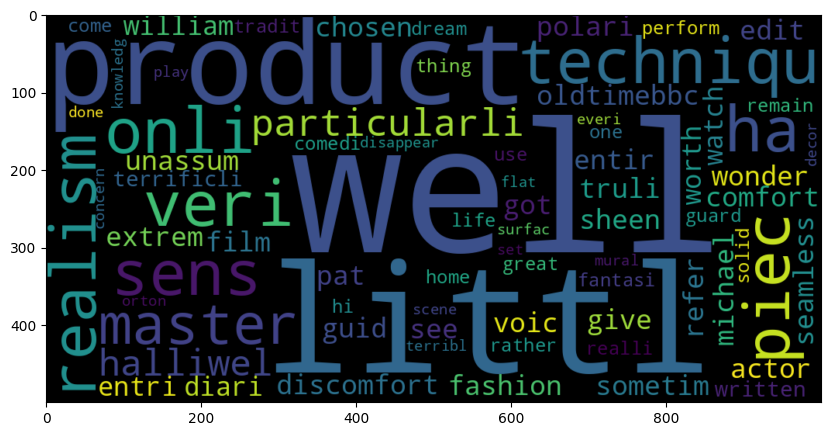

In [69]:
plt.figure(figsize=(10, 10))
positive_text = norm_train_reviews[1]
WC = WordCloud(width=1000, height=500, max_words=500, min_font_size=5)
positive_words = WC.generate(positive_text)
plt.imshow(positive_words, interpolation='bilinear')
plt.show

# Word cloud for negative words

<function matplotlib.pyplot.show(close=None, block=None)>

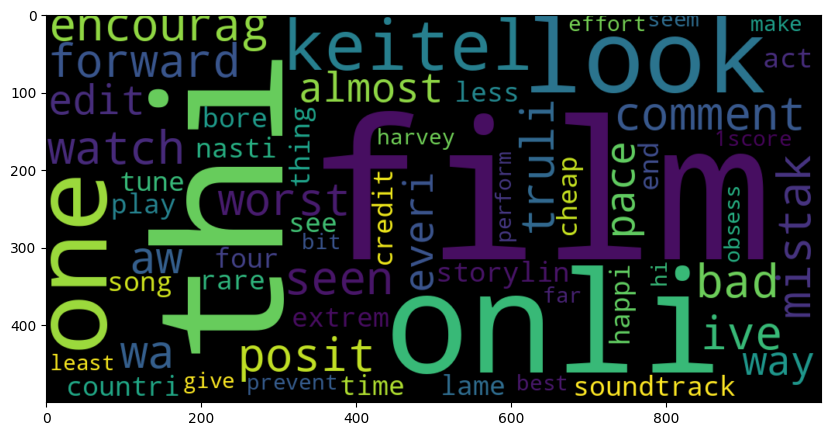

In [70]:
plt.figure(figsize=(10, 10))
positive_text = norm_train_reviews[8]
WC = WordCloud(width=1000, height=500, max_words=500, min_font_size=5)
positive_words = WC.generate(positive_text)
plt.imshow(positive_words, interpolation='bilinear')
plt.show